# The Momentum Factor — Single-Game Walkthrough

This case study assembles a scoring timeline for a single NBA game and derives momentum indicators for illustration.

In [12]:
# Bootstrap project root for imports
import sys, os, pathlib
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print("Project root:", PROJECT_ROOT)

Project root: /Users/suhruth/Desktop/Personal/nba_momentum_factor


In [13]:
from nba_api.stats.endpoints import playbyplayv2
import pandas as pd
from pathlib import Path
from scripts.momentum_utils import process_pbp, feature_pack
pd.set_option('display.max_columns', None)

## Step 1: Data Collection

Play-by-play data is retrieved for a specific game and persisted as raw CSV.

In [14]:
GAME_ID = "0022300001"  # LAL @ DEN, 2023-10-24
RAW_PATH = "../data/game_0022300001.csv"
pbp = playbyplayv2.PlayByPlayV2(game_id=GAME_ID)
df_raw = pbp.get_data_frames()[0].copy()
Path(RAW_PATH).parent.mkdir(parents=True, exist_ok=True)
df_raw.to_csv(RAW_PATH, index=False)
print(f"Raw saved → {RAW_PATH} | rows={len(df_raw):,}")
df_raw.head(8)

Raw saved → ../data/game_0022300001.csv | rows=473


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022300001,2,12,0,1,7:11 PM,12:00,None,Start of 1st Period (7:11 PM EST),None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
1,0022300001,4,10,0,1,7:11 PM,12:00,Jump Ball Turner vs. Allen: Tip to Toppin,None,None,None,None,4,1626167,Myles Turner,1.610613e+09,Indiana,Pacers,IND,5,1628386,Jarrett Allen,1.610613e+09,Cleveland,Cavaliers,CLE,4,1630167,Obi Toppin,1.610613e+09,Indiana,Pacers,IND,1
2,0022300001,7,1,108,1,7:12 PM,11:41,Turner 2' Cutting Dunk Shot (2 PTS) (Haliburto...,None,None,0 - 2,2,4,1626167,Myles Turner,1.610613e+09,Indiana,Pacers,IND,4,1630169,Tyrese Haliburton,1.610613e+09,Indiana,Pacers,IND,0,0,None,NaN,None,None,None,1
3,0022300001,9,2,47,1,7:12 PM,11:23,None,None,MISS Mobley 8' Turnaround Jump Shot,None,None,5,1630596,Evan Mobley,1.610613e+09,Cleveland,Cavaliers,CLE,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
4,0022300001,10,4,0,1,7:12 PM,11:20,Turner REBOUND (Off:0 Def:1),None,None,None,None,4,1626167,Myles Turner,1.610613e+09,Indiana,Pacers,IND,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
5,0022300001,11,2,41,1,7:12 PM,11:15,MISS Brown 2' Running Layup,None,None,None,None,4,1628971,Bruce Brown,1.610613e+09,Indiana,Pacers,IND,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
6,0022300001,12,4,0,1,7:12 PM,11:12,Brown REBOUND (Off:1 Def:0),None,None,None,None,4,1628971,Bruce Brown,1.610613e+09,Indiana,Pacers,IND,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
7,0022300001,13,1,1,1,7:12 PM,11:09,Mathurin 28' 3PT Jump Shot (3 PTS) (Brown 1 AST),None,None,0 - 5,5,4,1631097,Bennedict Mathurin,1.610613e+09,Indiana,Pacers,IND,4,1628971,Bruce Brown,1.610613e+09,Indiana,Pacers,IND,0,0,None,NaN,None,None,None,1


## Step 2: Data Preparation

Transform to an analysis-ready timeline (reg/OT handling), parse cumulative scores, and compute base differential.

In [15]:
df_proc = process_pbp(df_raw)
print(df_proc.head(10))

      GAME_ID  PERIOD PCTIMESTRING  total_seconds_elapsed  \
0  0022300001       1        11:41                     19   
1  0022300001       1        11:09                     51   
2  0022300001       1        10:56                     64   
3  0022300001       1        10:25                     95   
4  0022300001       1        10:14                    106   
5  0022300001       1         9:29                    151   
6  0022300001       1         9:29                    151   
7  0022300001       1         9:11                    169   
8  0022300001       1         9:00                    180   
9  0022300001       1         8:41                    199   

                                     HOMEDESCRIPTION  \
0  Turner 2' Cutting Dunk Shot (2 PTS) (Haliburto...   
1   Mathurin 28' 3PT Jump Shot (3 PTS) (Brown 1 AST)   
2                                               None   
3                                               None   
4  Turner 26' 3PT Jump Shot (5 PTS) (Mathurin 1 

## Step 3: Feature Engineering

Summarize run structure, swing magnitude, and stability; extract late-game momentum indicators and outcome alignment.

In [16]:
feats = feature_pack(df_proc)
feats

{'game_id': '0022300001',
 'home_win': 0,
 'final_margin': 5.0,
 'ot_game': 0,
 'diff_halftime': -17.0,
 'diff_q4start': -1.0,
 'diff_at_2min': -3.0,
 'momentum_l2_mean': -3.0555555555555554,
 'max_run_points': 9.0,
 'avg_run_points': 2.5268817204301075,
 'stability_invvar': 0.03626067932604337,
 'last_lead_change_time': 2552.0,
 'decisive_last_lead_change': True}

## Step 4: Visualization

Momentum flow and distributional views for the case study game.

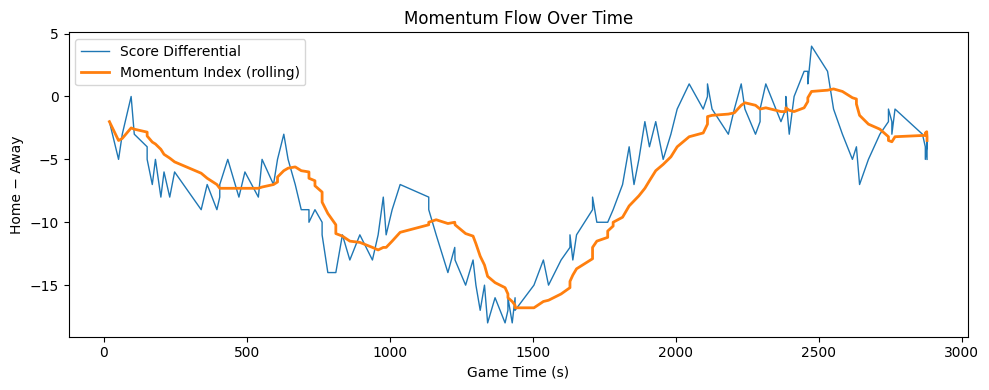

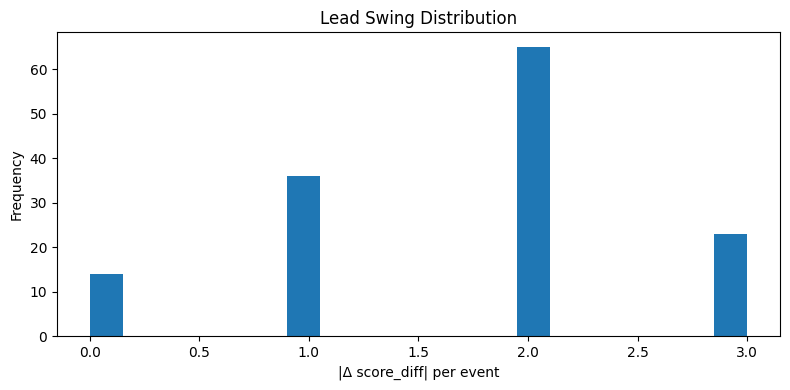

In [17]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, pathlib
pathlib.Path("../visuals").mkdir(parents=True, exist_ok=True)

# Momentum over time
plt.figure(figsize=(10,4))
plt.plot(df_proc["total_seconds_elapsed"], df_proc["score_diff"], label="Score Differential", linewidth=1)
plt.plot(df_proc["total_seconds_elapsed"], df_proc["momentum_index"], label="Momentum Index (rolling)", linewidth=2)
plt.xlabel("Game Time (s)"); plt.ylabel("Home − Away")
plt.title("Momentum Flow Over Time"); plt.legend(); plt.tight_layout()
plt.savefig("../visuals/momentum_over_time.png", dpi=160); plt.show()

# Lead swing distribution
plt.figure(figsize=(8,4))
plt.hist(df_proc["swing_magnitude"], bins=20)
plt.xlabel("|Δ score_diff| per event"); plt.ylabel("Frequency")
plt.title("Lead Swing Distribution"); plt.tight_layout()
plt.savefig("../visuals/lead_swing_distribution.png", dpi=160); plt.show()